In [ ]:
import numpy as np
from numpy.linalg import norm
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cvxpy as cp
import proxsuite
from matplotlib.patches import Polygon,Circle
import pickle




 

In [ ]:

# ==============================================================================
# 1. 시스템 동역학 정의 (다중 에이전트용)
# ==============================================================================

def multi_agent_const_speed_5d_dynamics(t, y, u_all_flat, n_agents, state_dim, V_const):
    """
    N_AGENTS개의 5차원 등속력 모델 동역학.
    상태: [px, py, vx, vy, theta], 제어: [omega]

    Args:
        t (float): 시간
        y (np.ndarray): 모든 에이전트의 상태 (n_agents * 5,1)
        u_all_flat (np.ndarray): 모든 에이전트의 제어 입력 (n_agents * 1,)
        n_agents (int): 에이전트 수
        state_dim (int): 상태 차원 (반드시 5)
        V_const (float): 모든 에이전트의 고정된 속력

    Returns:
        np.ndarray: 상태의 시간 미분 값
    """
    
    current_states = y.reshape((state_dim, n_agents), order='F')
    control_inputs = u_all_flat.reshape((1, n_agents), order='F')

    
    vx = current_states[2, :]     
    vy = current_states[3, :]
    theta = current_states[4, :]
    omega = control_inputs[0, :]

   
    d_state = np.zeros_like(current_states)
    
    # 위치의 변화율은 속도
    d_state[0, :] = vx
    d_state[1, :] = vy
    
    
    # d(vx)/dt = d/dt(V*cos(theta)) = -V*sin(theta)*(d(theta)/dt) = -V*sin(theta)*omega
    # d(vy)/dt = d/dt(V*sin(theta)) =  V*cos(theta)*(d(theta)/dt) =  V*cos(theta)*omega
    d_state[2, :] = -V_const * np.sin(theta) * omega
    d_state[3, :] =  V_const * np.cos(theta) * omega
    
    
    d_state[4, :] = omega
    

    
    return d_state.flatten('F')



In [ ]:


def relative_state(STATE_DIM, N_AGENTS, current_states_matrix):

    
  
    # p: positions (2, N_AGENTS), v: velocities (2, N_AGENTS), seta: angles (N_AGENTS,)
    p = current_states_matrix[0:2, :]
    v = current_states_matrix[2:4, :]
    seta = current_states_matrix[4, :]

    
    # (2, N, N) 형태의 텐서가 생성되며, 이 텐서의 [:, i, j] 원소가 (p_i - p_j)
    relative_p_tensor = p[:, :, np.newaxis] - p[:, np.newaxis, :]
    relative_v_tensor = v[:, :, np.newaxis] - v[:, np.newaxis, :]

    
    norm_relative_p = np.linalg.norm(relative_p_tensor, axis=0)
    norm_relative_v = np.linalg.norm(relative_v_tensor, axis=0)

    
    dot_relative_pv = np.sum(relative_p_tensor * relative_v_tensor, axis=0)

    
    relative_seta = np.sin(seta[np.newaxis, :] - seta[:, np.newaxis])

    
    vector_seta_all = np.vstack([-np.sin(seta), np.cos(seta)]) # shape: (2, N_AGENTS)

    
    dot_relative_p_seta = np.sum(vector_seta_all[:, :, np.newaxis] * (-relative_p_tensor), axis=0)

    return norm_relative_p, norm_relative_v, dot_relative_pv, relative_seta, dot_relative_p_seta

In [50]:


def ACS_flocking(u_limit, beta, lamda, k1, k2, desired_distance, N_AGENTS, V_CONST, pij_norm, vij_norm, pv_norm, seta_ij, p_dot_seta):
    """
    ACS_flocking 알고리즘의 벡터화 버전.
    For 루프를 제거하고 NumPy 배열 연산을 사용하여 모든 에이전트의 제어 입력을 동시에 계산합니다.

    주요 변경점:
    - 자기 자신과의 상호작용(i=j)을 제외하기 위해 np.delete 대신,
      행렬의 대각 성분을 0으로 만들어 sum() 연산에서 제외하는 기법을 사용합니다.
    - 0으로 나누는 것을 방지하기 위해 대각 성분을 임시로 1로 설정합니다.
    - np.clip을 사용하여 if문을 대체합니다.
    """

    # --- 1. Alignment Term (정렬 항) ---
    
    # 모든 에이전트 쌍에 대한 가중치를 한 번에 계산
    # Flocking original
    #align_weight_matrix = (1 + (pij_norm)**2)**(-beta) 

    align_weight_matrix = (1 + (pij_norm)**2)**(-beta)
    
    # 각 에이전트 i에 대해 다른 에이전트 j들의 가중합을 계산 (axis=1은 행 방향으로 더하는 것)
    u_align_all = (lamda / N_AGENTS) * np.sum(align_weight_matrix * seta_ij, axis=1)

    # --- 2. Inter-force Term (상호작용 힘 항) ---
    # pij_norm 행렬의 대각 성분은 0이므로, 0으로 나누는 오류를 방지하기 위해
    # 대각 성분을 1.0으로 잠시 바꾼 복사본을 생성합니다.
    # 최종 계산에서 대각 성분은 0으로 만들어져 합산에 영향을 주지 않으므로 안전합니다.
    pij_norm_safe = pij_norm.copy()
    np.fill_diagonal(pij_norm_safe, 1.0)

    # 상호작용 힘 계산의 각 부분을 행렬 단위로 한 번에 계산
    term_A_matrix = (k1 / (2 * pij_norm_safe**2)) * pv_norm
    term_B_matrix = (k2 * (pij_norm_safe - desired_distance) / (2 * pij_norm_safe)) * p_dot_seta
    
    # 두 항을 결합
    combined_matrix = term_A_matrix + term_B_matrix
    
    # 자기 자신과의 상호작용(i=j)을 제외하기 위해 대각 성분을 0으로 설정
    np.fill_diagonal(combined_matrix, 0)
    
    # 각 에이전트 i에 대해 다른 에이전트 j들과의 상호작용 힘을 모두 더함
    u_inter_all = (1 / (N_AGENTS * V_CONST)) * np.sum(combined_matrix, axis=1)

    # --- 3. 최종 제어 입력 계산 및 Saturation ---
    # 정렬 항과 상호작용 힘 항을 더함
    flocking_control = u_align_all + u_inter_all
    
    # Saturation: if문을 np.clip으로 대체하여 한 번에 처리
    flocking_control = np.clip(flocking_control, -u_limit*0.9, u_limit*0.9)
    
    # Truncation
    flocking_control = np.trunc(flocking_control * 1000) / 1000

    # 최종 출력 형태를 (N_AGENTS, 1)로 맞춤
    return flocking_control.reshape(-1, 1)

In [ ]:
def minimum_inter_distance_function(pij_norm, N_AGENTS):
    
    pij_with_inf_diag = pij_norm.copy()
    
    # 복사된 행렬의 대각선을 np.inf로 채웁니다.
    np.fill_diagonal(pij_with_inf_diag, np.inf)
    
    # 전체 행렬에서 최소값을 찾습니다.
    return np.min(pij_with_inf_diag)

In [ ]:
def maximum_inter_distance_function(pij_norm, N_AGENTS):
    
    pij_with_inf_diag = pij_norm.copy()
    
    
    np.fill_diagonal(pij_with_inf_diag, -1*np.inf)
    
    # 전체 행렬에서 최소값을 찾습니다.
    return np.max(pij_with_inf_diag)

In [ ]:
def fvo_cbf(pij_norm, vij_norm, pv_norm, N_AGENTS, V_CONST, critical_distance, current_states_matrix):
    """
    Control Barrier Function (CBF) 계산의 최적화된 벡터화 버전.
    조건부 마스킹(Boolean Indexing)을 사용하여 필요한 연산만 수행
    """
    np.seterr(divide='warn', invalid='warn')

    margin = 1e-4
    
    
    matrix_size = (N_AGENTS * (N_AGENTS - 1)) // 2
    rows, cols = np.triu_indices(N_AGENTS, k=1)

    seta = current_states_matrix[4, :]
    p_vector = current_states_matrix[0:2, :]
    v_vector = current_states_matrix[2:4, :]

    # --- 2. 모든 쌍에 대한 상대 상태 벡터 및 값 미리 계산 ---
    pij_vectors = p_vector[:, rows] - p_vector[:, cols]
    vij_vectors = v_vector[:, rows] - v_vector[:, cols]

    pij_norm_pairs = pij_norm[rows, cols]
    vij_norm_pairs = vij_norm[rows, cols]
    pv_norm_pairs = pv_norm[rows, cols]
    
    # 결과 저장용 배열 미리 할당 (0으로 초기화)
    h_x = np.zeros(matrix_size)
    Lfx = np.zeros(matrix_size)
    grad_vij = np.zeros((2, matrix_size))

    

    
    sqrt_term_all = np.sqrt(pij_norm_pairs**2 - critical_distance**2)
    
    # 2. VO 수식 계산
    # Gradient calculation
    grad_term = (sqrt_term_all / vij_norm_pairs)
    grad_vij = pij_vectors + grad_term[np.newaxis, :] * vij_vectors
        
    # h(x) calculation
    h_x = pv_norm_pairs + vij_norm_pairs * sqrt_term_all
        
    # Lfx calculation
    ca1 = vij_norm_pairs / sqrt_term_all
    Lfx = (vij_norm_pairs**2) + ca1 * pv_norm_pairs

    
    # --- 5. Margin 적용 ---
    h_x = h_x - margin

   
    g_i_all = V_CONST * np.vstack([-np.sin(seta), np.cos(seta)]) 
    g_j_all = V_CONST * np.vstack([np.sin(seta), -np.cos(seta)]) 
    
    g_i_pairs = g_i_all[:, rows]
    g_j_pairs = g_j_all[:, cols] 
    
    lg_i = np.sum(g_i_pairs * grad_vij, axis=0)
    lg_j = np.sum(g_j_pairs * grad_vij, axis=0)
    
    Lgh = np.zeros((matrix_size, N_AGENTS))
    row_indices_for_lgh = np.arange(matrix_size)
    Lgh[row_indices_for_lgh, rows] = lg_i
    Lgh[row_indices_for_lgh, cols] = lg_j

    
    return h_x.reshape(-1, 1), Lfx.reshape(-1, 1), Lgh

In [ ]:
def solve_cbf_qp_with_warm_start(n,n_in,qp, x_warm, y_warm, z_warm, 
                                 h_vector, lfh_vector, lgh_matrix, 
                                 u_nominal, u_limit, class_k, t):
    """
    미리 초기화된 Proxsuite QP 객체와 웜 스타트를 사용하여 CBF-QP 문제를 해결합니다.
    """
    # --- 수정된 부분 시작 ---
    # qp.model에서 읽어오는 대신, 문제의 차원을 직접 정의합니다.
    
    # --- 수정된 부분 끝 ---
    p_u=0.5

    # 2단계: QP 행렬 구성 (이전과 동일)
    H = p_u * np.identity(n)
    g = -p_u* u_nominal.flatten()
    A, b = None, None

    # 지금 이 부분은 유한시간 class-k을 적용하는 버전임 

    
    C_cbf = lgh_matrix
    l_cbf = -class_k * h_vector.flatten() - lfh_vector.flatten()
    u_cbf = np.full(n_in - n, np.inf)
    
    C_box = np.identity(n)
    l_box = -u_limit * np.ones(n)
    u_box = u_limit * np.ones(n)
    
    C = np.vstack([C_cbf, C_box])
    l = np.concatenate([l_cbf, l_box])
    u = np.concatenate([u_cbf, u_box])

    
    qp.init(H, g, A, b, C, l, u)
    qp.solve(x_warm, y_warm, z_warm)

    # 4단계: 해 검색 및 처리 (이전과 동일)
    if qp.results.info.status == proxsuite.proxqp.QPSolverOutput.PROXQP_SOLVED:
        optimal_u = qp.results.x.reshape(-1, 1)
        return optimal_u
    else:
        print(f"Problem could not be solved. Status: {qp.results.info.status}")
        print(t)
        return None

In [ ]:
def calculate_std_dev(states_matrix, n_agents):
    """
    주어진 상태 행렬(위치 또는 속도)의 공간적 표준편차를 계산합니다.
    MATLAB 코드의 로직과 동일하게 구현: sqrt((1/N) * sum(diag(X_centered' * X_centered)))
    
    Args:
        states_matrix (np.ndarray): (2, N_AGENTS) 형태의 위치 또는 속도 행렬.
        n_agents (int): 에이전트의 수.

    Returns:
        float: 계산된 표준편차.
    """
    if n_agents == 0:
        return 0.0
    
    
    mean_vec = np.mean(states_matrix, axis=1, keepdims=True)
    
    
    centered_matrix = states_matrix - mean_vec
    
   
    sum_of_squared_distances = np.sum(centered_matrix**2)
    
    
    std_dev = np.sqrt(sum_of_squared_distances / n_agents)
    
    return std_dev

In [ ]:
def plot_initial_conditions(initial_states_matrix):
    """
    Visualizes the generated initial states.
    - Drones are represented as blue isosceles triangles following their heading.
    - The two closest drones are connected by a red dashed line.
    - The minimum distance is displayed at the top.

    Args:
        initial_states_matrix (np.ndarray): A 5xN_AGENTS matrix of initial states.
    """
    N_AGENTS = initial_states_matrix.shape[1]

    # Plot setup
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Safe Initial States Visualization', fontsize=16)
    ax.set_xlabel('X Position (m)')
    ax.set_ylabel('Y Position (m)')
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle='--', alpha=0.6)

    min_dist = float('inf')
    closest_pair_indices = (-1, -1)

    # 1. Plot all drones as triangles
    for i in range(N_AGENTS):
        # Drone position and heading
        px, py = initial_states_matrix[0, i], initial_states_matrix[1, i]
        theta = initial_states_matrix[4, i]

        # Define triangle vertices (for heading 0)
        triangle_points = np.array([
            [10, 0],    # 드론 크기 조절
            [-10, 6],
            [-10, -6]
        ])

        # Rotate by heading angle (theta)
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        
        rotated_points = triangle_points @ rotation_matrix.T

        # Translate to position (px, py)
        transformed_points = rotated_points + np.array([px, py])

        # Draw the triangle
        ax.add_patch(Polygon(transformed_points, closed=True, color='blue'))

    # 2. Find the two closest drones
    if N_AGENTS > 1:
        for i in range(N_AGENTS):
            for j in range(i + 1, N_AGENTS):
                pos_i = initial_states_matrix[0:2, i]
                pos_j = initial_states_matrix[0:2, j]
                distance = np.linalg.norm(pos_i - pos_j)
                
                if distance < min_dist:
                    min_dist = distance
                    closest_pair_indices = (i, j)

    # 3. Connect the closest drones and display the distance
    if closest_pair_indices[0] != -1:
        idx1, idx2 = closest_pair_indices
        p1 = initial_states_matrix[0:2, idx1]
        p2 = initial_states_matrix[0:2, idx2]

        # Connect with a red dashed line
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r--', label=f'Min Distance: {min_dist:.2f} m')

        # Display minimum distance text at the top
        ax.text(0.5, 1.05, f'Minimum Distance: {min_dist:.2f} m', 
                ha='center', va='bottom', transform=ax.transAxes, 
                fontsize=14, color='red', fontweight='bold')

    # Set plot limits
    if N_AGENTS > 0:
        all_x = initial_states_matrix[0, :]
        all_y = initial_states_matrix[1, :]
        x_range = np.max(all_x) - np.min(all_x)
        y_range = np.max(all_y) - np.min(all_y)
        margin = max(x_range, y_range) * 0.1 if max(x_range, y_range) > 0 else 1
        ax.set_xlim(np.min(all_x) - margin, np.max(all_x) + margin)
        ax.set_ylim(np.min(all_y) - margin, np.max(all_y) + margin)
    else:
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 10)

    # Show legend and plot
    if N_AGENTS > 1:
        ax.legend()
    plt.show()



In [ ]:


# ==============================================================================
# 2. 시뮬레이션 루프 (사용자 코드를 5차원 모델에 맞게 수정한 버전)
# ==============================================================================
def run_multi_agent_simulation(N_AGENTS,V_CONST, critical_distance,initial_states_matrix):
    # --- 시뮬레이션 파라미터 ---
    
    # 실행가능성 판단 문장
    feasible=1

    # 초기상태에 대한 위치와 속도의 표준편차 계산
    position_std_dev = calculate_std_dev(initial_states_matrix[0:2, :], N_AGENTS)
    velocity_std_dev = calculate_std_dev(initial_states_matrix[2:4, :], N_AGENTS)

    T_FINAL = 600
    DT_CONTROL = 0.05



    # -- 기체 파라미터 --
    
    u_limit=0.35  # rad

    # -- ACS 파라미터 
    beta=np.load('beta.npy')
    lamda=np.load('lamda.npy')
    k1=np.load('k1.npy')
    k2=np.load('k2.npy')
    desired_distance=np.load('desired_distance.npy')



    # CBF parameter
    
    class_k=np.load('class_k.npy')

    # warm_start_define
    # 1. 문제 차원 정의
   
    n=N_AGENTS
    n_eq = 0  # 등식 제약 조건 없음
    n_in=int(N_AGENTS*(N_AGENTS-1)/2)+N_AGENTS

    # 2. ProxQP 솔버 객체 생성 (단 한 번만!)
    qp = proxsuite.proxqp.sparse.QP(n, n_eq, n_in)

    # 3. 솔버 설정 
    qp.settings.max_iter = 4000
    qp.settings.eps_abs = 1e-6
    qp.settings.eps_rel = 0

    # 4. 웜 스타팅을 위한 변수 초기화
    # x_warm: u의 이전 해 (primal solution)
    # y_warm: 등식 제약조건의 이전 해 (dual solution)
    # z_warm: 부등식 제약조건의 이전 해 (dual solution)
    x_warm = np.zeros(n)
    y_warm = np.zeros(n_eq)
    z_warm = np.zeros(n_in)
    
    y0 = initial_states_matrix.flatten('F')

    # --- 시뮬레이션 변수  단일 시뮬레이션 상황 ---
    times = np.arange(0, T_FINAL, DT_CONTROL)
    history = [initial_states_matrix]
    control_history=[]
    minimum_distance_history=[]
    minimum_h_history=[]

    maximum_distance_history=[]
    current_y = y0

    #-- 많은 테스트케이스에 대한 결과 저장---
    
    


   

    print("5D Simulation starting...")
    
    for t in times[:-1]:

        
        current_states_matrix = current_y.reshape((STATE_DIM, N_AGENTS), order='F') # 지금 cbf에서 들어가는 값임 [5,10]
        current_states_matrix[4, :] = (current_states_matrix[4, :] + np.pi) % (2 * np.pi) - np.pi
        

        
        # relative state information build start

        pij_norm=np.zeros((N_AGENTS,N_AGENTS))
        vij_norm=np.zeros((N_AGENTS,N_AGENTS))
        pv_norm=np.zeros((N_AGENTS,N_AGENTS))
        seta_ij=np.zeros((N_AGENTS,N_AGENTS))
        p_dot_seta=np.zeros((N_AGENTS,N_AGENTS))
        pij_norm,vij_norm,pv_norm,seta_ij,p_dot_seta=relative_state(STATE_DIM, N_AGENTS,current_states_matrix)

        # relative state information build end

        # Calculate minimum distance start
        minimum_inter_distance=0
        minimum_inter_distance=minimum_inter_distance_function(pij_norm,N_AGENTS)
        minimum_distance_history.append(minimum_inter_distance)

       # print(minimum_inter_distance,t)

        maximum_inter_distance=0
        maximum_inter_distance=maximum_inter_distance_function(pij_norm,N_AGENTS)
        maximum_distance_history.append(maximum_inter_distance)

        
        #print(maximum_inter_distance)

        # Calculate minimum distance end


        # Control barrier function start

        u_nominal=ACS_flocking(u_limit,beta,lamda,k1,k2,desired_distance ,N_AGENTS, V_CONST,pij_norm,vij_norm,pv_norm,seta_ij,p_dot_seta)
        # Control barrier function start_warm_start

        h_vector,lfh_vector,lgh_matrix=fvo_cbf(pij_norm, vij_norm, pv_norm,N_AGENTS, V_CONST,critical_distance,current_states_matrix)

        minimum_h=0
        minimum_h=min(h_vector.copy())
        minimum_h_history.append(minimum_h)


        # 수정된 함수 호출
        optimal_u = solve_cbf_qp_with_warm_start(n,n_in,
         qp, x_warm, y_warm, z_warm,  # 솔버 객체와 웜 스타트 변수 전달
         h_vector, lfh_vector, lgh_matrix, 
         u_nominal, u_limit, class_k, t
        )

        

        if optimal_u is not None:
          # --- 다음 이터레이션을 위해 현재 해를 저장 (웜 스타트 변수 업데이트) ---
          x_warm = qp.results.x
          y_warm = qp.results.y
          z_warm = qp.results.z
        
        #... (시스템에 optimal_u 적용)...
        else:
         # 해결 실패 시, 웜 스타트 변수를 업데이트하지 않고 이전 값을 유지하거나
         # 비상 정지 등 예외 처리 로직 수행
          print("infeasibility occur")
          feasible=0
          return None, None, None, None, None, None,feasible, None, None, None, None

        # 제어입력 save
        control_history.append(optimal_u.copy())
        #print(min(optimal_u))
        



        # --- 수치 적분 (한 제어 주기 동안) ---
        sol = solve_ivp(
            fun=multi_agent_const_speed_5d_dynamics, # (변경) 5차원 동역학 함수로 교체
            t_span=[t, t + DT_CONTROL],
            y0=current_y,
            # (변경) V_CONST를 동역학 함수에 추가 인자로 전달
            args=(optimal_u, N_AGENTS, STATE_DIM, V_CONST)
        )

        # print(optimal_u)
        
        # 다음 스텝을 위해 상태 업데이트 및 기록
        current_y = sol.y[:, -1]  #[5*10,1]
        history.append(current_y.reshape((STATE_DIM, N_AGENTS), order='F')) # [total_time_step,state,agent_num]
        
        
    
    print("Simulation finished.")
    print("feasible:", feasible)

    # 최종상태에 대한 표준편차 계산
    final_states_matrix = history[-1]
    final_position_std_dev = calculate_std_dev(final_states_matrix[0:2, :], N_AGENTS)
    final_velocity_std_dev = calculate_std_dev(final_states_matrix[2:4, :], N_AGENTS)

    return (times, np.array(history), np.array(control_history),
            np.array(minimum_distance_history), np.array(maximum_distance_history),
            np.array(minimum_h_history), feasible, position_std_dev, velocity_std_dev,
            final_position_std_dev, final_velocity_std_dev)




In [58]:
# --- 초기 상태 설정 (5차원) ---

N_AGENTS =np.load('N_AGENTS.npy')
V_CONST = np.load('V_CONST.npy')
critical_distance=np.load('critical_distance.npy')
STATE_DIM = np.load('STATE_DIM.npy')
initial_test_case=np.load('initial_test_case.npy')
test_case_num=np.load('test_case_num.npy')

In [ ]:
fvo_total_history=[]
fvo_total_control_history=[]
fvo_total_minimum_distance_history=[]
fvo_total_maximum_distance_history=[]
fvo_total_minimum_h_history=[]
fvo_feasibility_test_cases=[]
fvo_initial_position_std_dev_list=[]
fvo_initial_velocity_std_dev_list=[]
fvo_final_position_std_dev_list=[]
fvo_final_velocity_std_dev_list=[]

In [ ]:
# 시뮬레이션 실행
for test_case in range(test_case_num):
    print(f"Running simulation for test case {test_case }...")
    initial_states_matrix=initial_test_case[:,:,test_case]
    times, history,heading_angel_rate,smallist_distance ,largiest_distance,smallist_h,feasiblity,initial_position_std_dev, initial_velocity_std_dev, final_position_std_dev, final_velocity_std_dev = run_multi_agent_simulation(N_AGENTS,V_CONST, critical_distance,initial_states_matrix)
    
    if feasiblity==1:
        fvo_total_history.append(history)
        fvo_total_control_history.append(heading_angel_rate)
        fvo_total_minimum_distance_history.append(smallist_distance)
        fvo_total_maximum_distance_history.append(largiest_distance)
        fvo_total_minimum_h_history.append(smallist_h)
        fvo_feasibility_test_cases.append(test_case)
        fvo_initial_position_std_dev_list.append(initial_position_std_dev)
        fvo_initial_velocity_std_dev_list.append(initial_velocity_std_dev)
        fvo_final_position_std_dev_list.append(final_position_std_dev)
        fvo_final_velocity_std_dev_list.append(final_velocity_std_dev)   

    # 루프가 끝난 후 전체 결과 출력
    print(f"\n--- Simulation Summary ---")
    print(f"Feasible cases: {len(fvo_feasibility_test_cases)} / {test_case_num}")
    if test_case_num > 0:
        feasibility_rate = (len(fvo_feasibility_test_cases) / test_case_num) * 100
        print(f"Feasibility Rate: {feasibility_rate:.2f}%")




Running simulation for test case 0...
5D Simulation starting...
Simulation finished.
feasible: 1

--- Simulation Summary ---
Feasible cases: 1 / 10
Feasibility Rate: 10.00%
Running simulation for test case 1...
5D Simulation starting...
Simulation finished.
feasible: 1

--- Simulation Summary ---
Feasible cases: 2 / 10
Feasibility Rate: 20.00%
Running simulation for test case 2...
5D Simulation starting...
Simulation finished.
feasible: 1

--- Simulation Summary ---
Feasible cases: 3 / 10
Feasibility Rate: 30.00%
Running simulation for test case 3...
5D Simulation starting...
Simulation finished.
feasible: 1

--- Simulation Summary ---
Feasible cases: 4 / 10
Feasibility Rate: 40.00%
Running simulation for test case 4...
5D Simulation starting...
Simulation finished.
feasible: 1

--- Simulation Summary ---
Feasible cases: 5 / 10
Feasibility Rate: 50.00%
Running simulation for test case 5...
5D Simulation starting...
Simulation finished.
feasible: 1

--- Simulation Summary ---
Feasible c

In [61]:


# ==============================================================================
# 시뮬레이션 애니메이션 생성 함수 (MATLAB 스타일 완벽 적용 최종본)
# ==============================================================================
def create_simulation_animation(history, times, filename='drone_simulation.mp4', fps=30, frame_skip=1):
    """
    제공된 MATLAB 코드의 시각화 방식을 그대로 구현한 최종 버전입니다.
    - Zoom-to-fit 뷰: 매 프레임마다 모든 드론을 포함하도록 뷰의 중심과 크기를 조절합니다.
    - 동적 드론 크기: 뷰의 크기에 비례하여 드론의 크기가 조절됩니다.
    - 고정 정보 텍스트: 화면 좌측/우측 상단에 시간, 최소 거리 정보가 표시됩니다.
    - 최종 목표 원 표시: 마지막 프레임에서 군집 중심에 목표 원을 표시합니다.

    Args:
        history (np.ndarray): (타임스텝, 상태차원, 에이전트 수) 크기의 배열.
        times (np.ndarray): 시뮬레이션 시간 배열.
        filename (str): 저장할 동영상 파일 이름.
        fps (int): 동영상의 초당 프레임 수 (Hz).
        frame_skip (int): 렌더링 속도를 높이기 위한 프레임 건너뛰기 간격.
    """
    
    if len(history) == 0:
        print("Warning: History is empty. Cannot create animation.")
        return

    # 프레임 건너뛰기 적용
    if frame_skip > 1:
        print(f"Applying frame skip: Rendering 1 of every {frame_skip} frames.")
        history = history[::frame_skip]
        times = times[::frame_skip]

    N_AGENTS = history.shape[2]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Artist 객체 초기화
    drones = [ax.add_patch(Polygon([[0,0], [0,0]], closed=True, color='blue', zorder=10)) for _ in range(N_AGENTS)]
    closest_line, = ax.plot([], [], 'r--', zorder=5)
    info_text_left = ax.text(0.02, 0.98, '', transform=ax.transAxes, fontsize=12, verticalalignment='top', 
                             bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    info_text_right = ax.text(0.98, 0.98, '', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right',
                              bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    final_circle = Circle((0, 0), 250, edgecolor='g', facecolor='none', linewidth=2, visible=False, zorder=5)
    ax.add_patch(final_circle)

    def update(frame):
        current_states = history[frame]
        min_dist = float('inf')
        closest_pair_indices = (-1, -1)
        
        # --- MATLAB 스타일 뷰 설정 ---
        current_positions = current_states[0:2, :]
        center = np.mean(current_positions, axis=1)
        distances = np.linalg.norm(current_positions - center[:, np.newaxis], axis=0)
        
        # 모든 드론을 포함하는 최소 시야 반경 계산 (여백 포함)
        axis_range = np.max(distances) + 20 

        # 마지막 프레임일 경우, 목표 원이 보이도록 시야를 추가로 확보
        if frame == len(history) - 1:
            axis_range = max(axis_range, 250 + 20)
            
            # 목표 원 위치 설정 및 표시
            final_center = np.mean(current_states[0:2, :], axis=1)
            final_circle.set_center(final_center)
            final_circle.set_visible(True)

        # 축 범위 설정
        ax.set_xlim(center[0] - axis_range, center[0] + axis_range)
        ax.set_ylim(center[1] - axis_range, center[1] + axis_range)

        # --- MATLAB 스타일 동적 드론 크기 ---
        view_width = 2 * axis_range
        # 뷰 크기에 비례하여 드론 크기 조절 (MATLAB 로직과 유사하게 구현)
        base_size = 20
        dynamic_size = max(5, min(base_size * (view_width / 500), 20)) # 뷰가 500m일때 기본 크기
        
        # 드론 모양 템플릿 (MATLAB과 유사한 형태)
        shape_template = np.array([
            [1, 0],
            [-1, 0.5],
            [-1, -0.5]
        ]) * dynamic_size * 0.8


        # 모든 드론의 위치 및 방향 업데이트
        for i in range(N_AGENTS):
            px, py, theta = current_states[0, i], current_states[1, i], current_states[4, i]
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
            rotated_points = shape_template @ rotation_matrix.T # 회전
            transformed_points = rotated_points + np.array([px, py]) # 이동
            drones[i].set_xy(transformed_points)

        # 가장 가까운 두 드론 찾기
        for i in range(N_AGENTS):
            for j in range(i + 1, N_AGENTS):
                pos_i = current_states[0:2, i]
                pos_j = current_states[0:2, j]
                distance = np.linalg.norm(pos_i - pos_j)
                if distance < min_dist:
                    min_dist = distance
                    closest_pair_indices = (i, j)
        
        # 가장 가까운 드론 연결선 업데이트
        if closest_pair_indices[0] != -1:
            idx1, idx2 = closest_pair_indices
            p1 = current_states[0:2, idx1]
            p2 = current_states[0:2, idx2]
            closest_line.set_data([p1[0], p2[0]], [p1[1], p2[1]])
        else:
            closest_line.set_data([], [])

        # 고정 정보 텍스트 업데이트
        left_text = f'Min Distance: {min_dist:.2f} m'
        right_text = f'Time: {times[frame]:.2f} s'
        info_text_left.set_text(left_text)
        info_text_right.set_text(right_text)
        
        # 플롯 제목 및 라벨 설정 (매번 다시 설정하여 폰트 깨짐 방지)
        ax.set_title('Drone Swarm Simulation', fontsize=16)
        ax.set_xlabel('X Position (m)')
        ax.set_ylabel('Y Position (m)')
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, linestyle='--', alpha=0.6)
        
        return drones + [closest_line, info_text_left, info_text_right, final_circle]

    # 애니메이션 생성
    ani = animation.FuncAnimation(fig, update, frames=len(history), interval=50, blit=False)
    
    # 동영상으로 저장
    print(f"Saving animation to {filename} at {fps} FPS... (Rendering {len(history)} frames)")
    try:
        ani.save(filename, writer='ffmpeg', fps=fps)
        print("Animation saved successfully.")
    except Exception as e:
        print(f"Error saving animation: {e}")
        print("Please ensure 'ffmpeg' is installed and accessible in your system's PATH.")
        
    plt.close(fig)



In [ ]:
# 


fvo_data={

    'fvo_total_history':fvo_total_history,
    'fvo_total_control_history':fvo_total_control_history,
    'fvo_total_minimum_distance_history':fvo_total_minimum_distance_history,
    'fvo_total_maximum_distance_history':fvo_total_maximum_distance_history,
    'fvo_total_minimum_h_history':fvo_total_minimum_h_history,
    'fvo_feasibility_test_cases':fvo_feasibility_test_cases,
    'fvo_initial_position_std_dev_list':fvo_initial_position_std_dev_list,
    'fvo_initial_velocity_std_dev_list':fvo_initial_velocity_std_dev_list,
    'fvo_final_position_std_dev_list':fvo_final_position_std_dev_list,
    'fvo_final_velocity_std_dev_list':fvo_final_velocity_std_dev_list

}

with open("fvo_simulation_data.pkl", "wb") as f:
    pickle.dump(fvo_data, f)

    print("저장이 완료되었습니다! 폴더에 fvo_simulation.pkl 파일이 생김.")

Squeezed shape: (11999, 5)


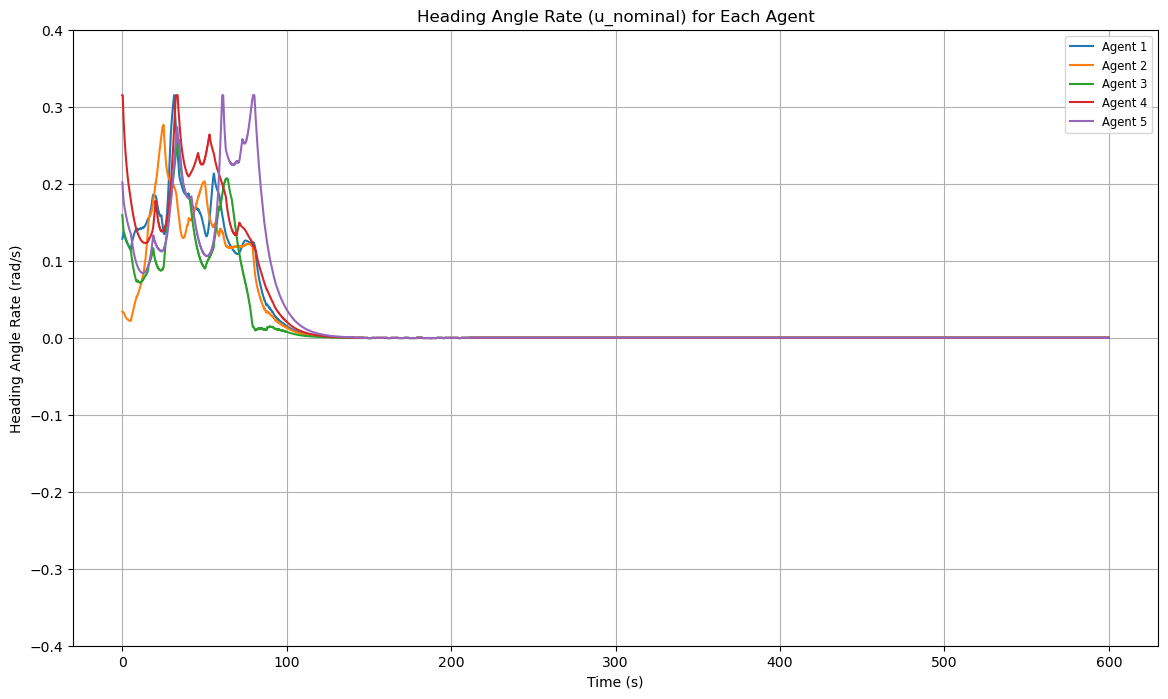

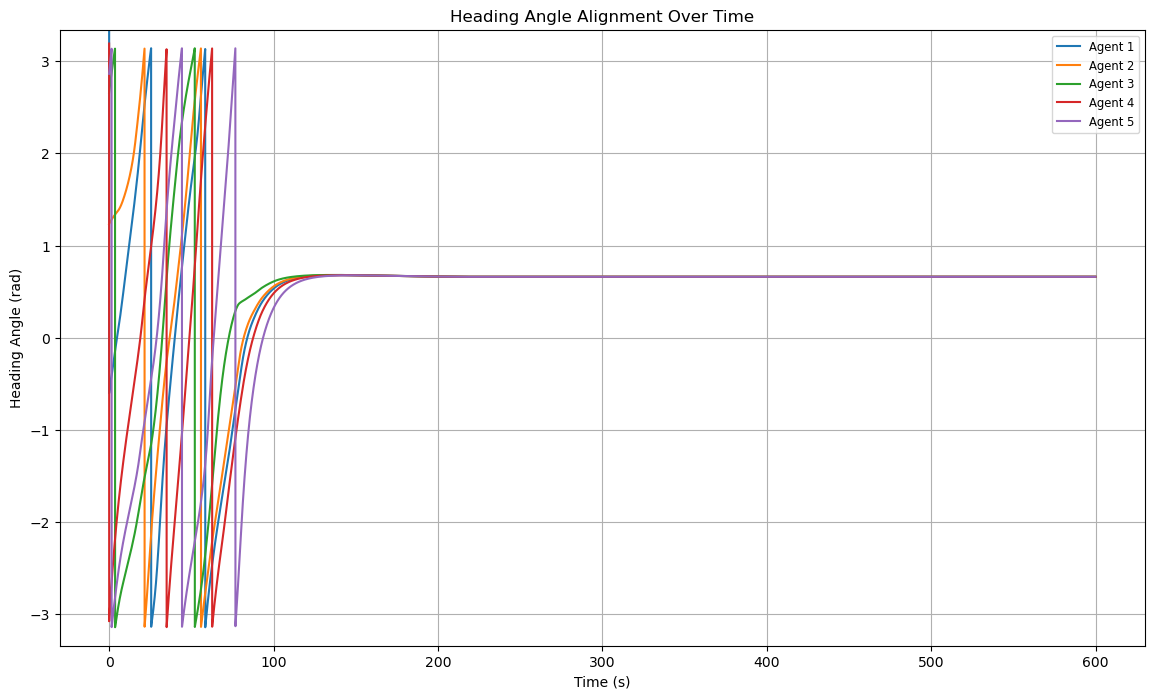

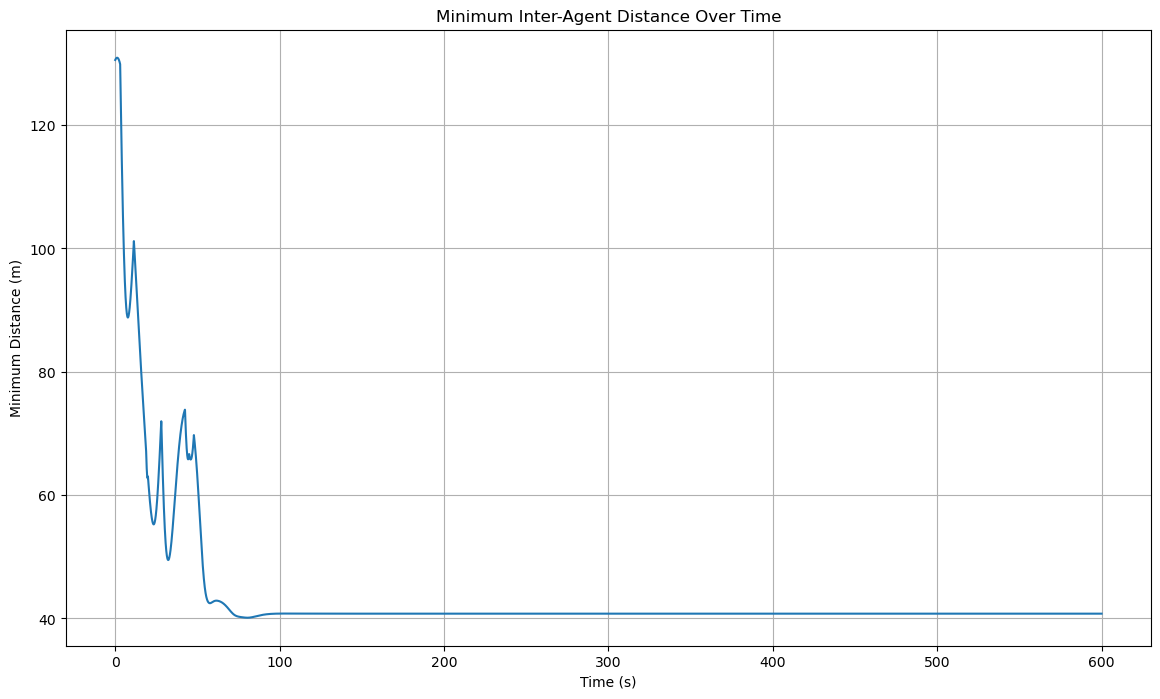

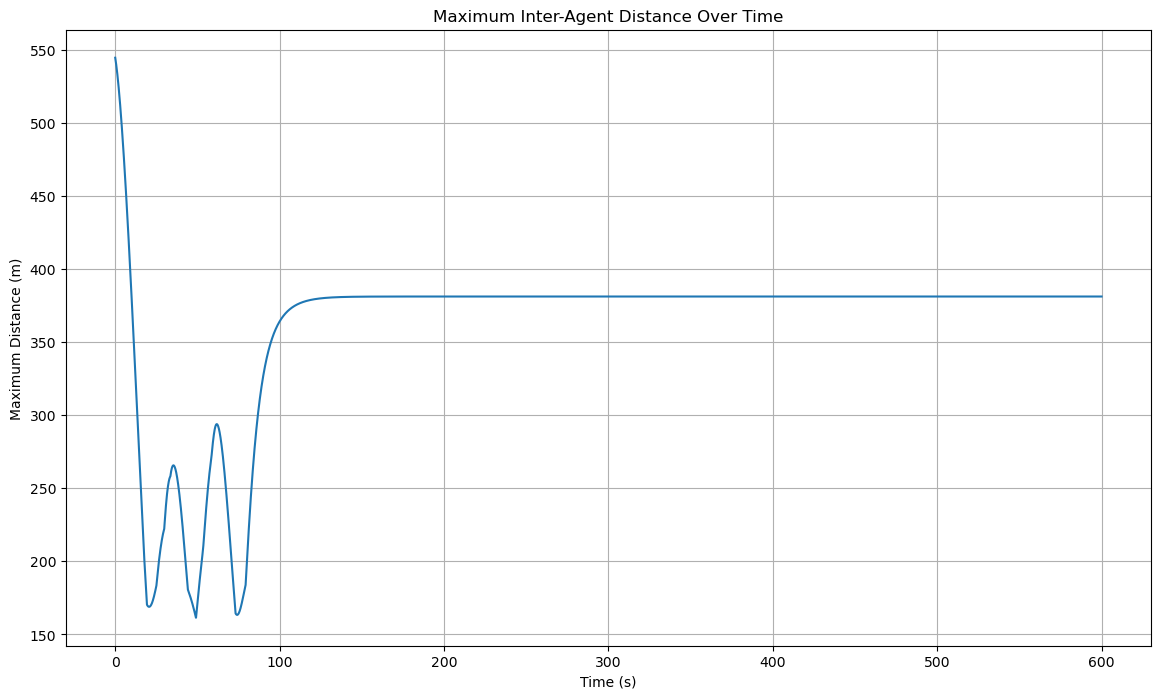

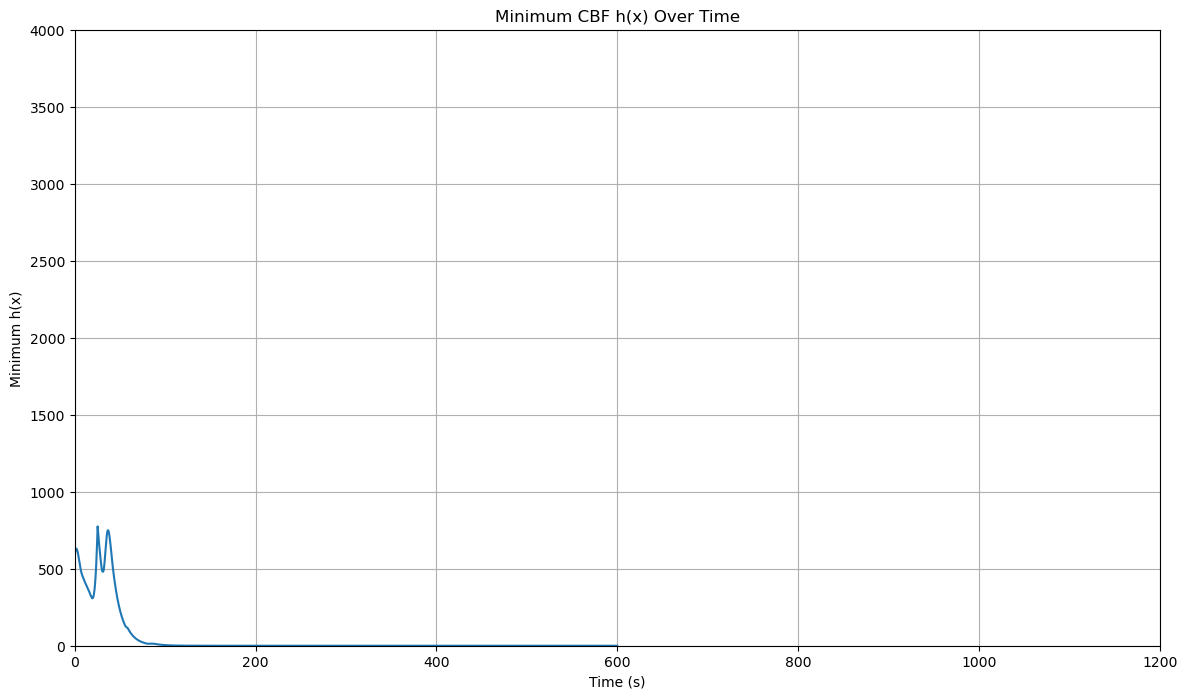

In [ ]:
choose_test_case=0
# 여기서는 보고 싶은 test case을 선정하는 내용임

squeezed_rate = np.squeeze(fvo_total_control_history[choose_test_case])  # (time_steps, N_AGENTS)
print("Squeezed shape:", squeezed_rate.shape)

plt.figure(figsize=(14, 8))
plt.title("Heading Angle Rate (u_nominal) for Each Agent")
plt.xlabel("Time (s)")
plt.ylabel("Heading Angle Rate (rad/s)")

# 3. 시간 축 데이터 준비
# heading_angel_rate의 데이터 개수와 길이를 맞추기 위해 times 배열의 마지막 값을 제외합니다.
simulation_times = times[:-1]

# 4. 각 에이전트에 대해 반복하며 플로팅
num_agents = squeezed_rate.shape[1]  # 에이전트 수 = 10
for i in range(N_AGENTS):
    # squeezed_rate[:, i]는 i번째 에이전트의 전체 시간 데이터를 의미합니다.
    plt.plot(simulation_times, squeezed_rate[:, i], label=f'Agent {i+1}')

plt.ylim([-0.4, 0.4])
plt.grid(True)
plt.legend(loc='upper right', fontsize='small') # 범례가 너무 크지 않게 조절
plt.show()


#=============================================================================

# alignment 확인용

# (수정) 새 그래프를 위한 Figure 생성
plt.figure(figsize=(14, 8))
# (수정) 누락된 제목 추가
plt.title("Heading Angle Alignment Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Heading Angle (rad)")

simulation_times_for_alignment = times
fvo_selected_history = fvo_total_history[choose_test_case]
alignment_check=fvo_selected_history[:,4,:]
num_agents = alignment_check.shape[1] # (수정) num_agents를 여기서 다시 정의
for i in range(num_agents):
    # squeezed_rate[:, i]는 i번째 에이전트의 전체 시간 데이터를 의미합니다.
    plt.plot(simulation_times_for_alignment, alignment_check[:,i], label=f'Agent {i+1}')


plt.ylim([-np.pi - 0.2, np.pi + 0.2]) # Wrapping 했으므로 범위 설정
plt.grid(True)
plt.legend(loc='upper right', fontsize='small') # 범례가 너무 크지 않게 조절
plt.show()


# ==============================================================================
plt.figure(figsize=(14, 8))
simulation_times = times[:-1]
selected_min_distance = fvo_total_minimum_distance_history[choose_test_case]
plt.title("Minimum Inter-Agent Distance Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Minimum Distance (m)")
plt.plot(simulation_times,selected_min_distance)
# (수정) 현재 그래프를 그리고 다음으로 넘어가기 위해 show() 호출
plt.grid(True)
plt.show()


# (수정) 새 그래프를 위한 Figure 생성
plt.figure(figsize=(14, 8))
simulation_times = times[:-1]
selected_max_distance = fvo_total_maximum_distance_history[choose_test_case]
plt.title("Maximum Inter-Agent Distance Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Maximum Distance (m)")
plt.plot(simulation_times,selected_max_distance)
# (수정) 현재 그래프를 그리고 다음으로 넘어가기 위해 show() 호출
plt.grid(True)
plt.show()



# (수정) 새 그래프를 위한 Figure 생성
plt.figure(figsize=(14, 8))
simulation_times = times[:-1]
selected_smallist_h = fvo_total_minimum_h_history[choose_test_case]
plt.ylim([0,4000])
plt.xlim([0,1200])
plt.title("Minimum CBF h(x) Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Minimum h(x)")
plt.plot(simulation_times,selected_smallist_h)
# (수정) 마지막 그래프를 그림
plt.grid(True)
plt.show()

In [ ]:
do_you_want_animation = False  # 애니메이션 생성 여부 설정

if do_you_want_animation:
    create_simulation_animation(
    history=fvo_selected_history, 
    times=times,
    filename='fvo fast_simulation.mp4', 
    fps=60, 
    frame_skip=30
)
